# Coefficient Estimation for NEWT

At this point, we have established that, with the available periods-of-record, a stationary SCHEMA works quite well, though some sort of dynamism is likely to help with longer-range applications.  Still, the emphasis is on short-term and S2S forecasting, so long-range efficiency isn't critical (and, more to the point, can be returned to later).  Now, let's look at coefficient estimation, where dynamic fitting is likely to be more important.

Here's the basic idea.  We want to be able to run a watershed model without pre-feeding years of data, but we also want to benefit from data on atmospheric conditions.  How should we proceed?

- Develop one fit for model coefficients based only on static surface conditions (XYZ, slope and aspect, land cover/LAI, drainage area)
- Develop a separate fit for model coefficients based only on dynamic conditions (mean precipitation, temperature, and humidity; land cover/LAI again; soil moisture; aridity)
- Tune two "drift rates": climate drift (rate of convergence from static-only to climate-only; possibly with a final equilibrium weighting), and recency weight (weighting of climate over time, controlling speed of correction for climate shifts)

For early reporting, I will prototype this with a single model accounting for all data.  Then, I'll build a static-only watershed model generator and a climate-drift model modification engine for the final implementation.

One challenge is that the optimal GAM seems to be *highly* sensitive to the optimization process, since variables may balance or substitute each other in unexpected ways.  Really, the ideal would be a rigorous, global optimization approach.  The problem is that this generates a vast number of possibilities, and it's unclear whether it can be efficiently run: 32 possible predictors.  Though it is quite fast, so maybe it is tractable, at least up to a point (say, all possibilities to an upper limit of 10 predictors).

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis, engines

In [2]:
def idfix(data):
    data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
    data["id"] = data["id"].apply(lambda x: x.split("_")[1])
    return data

In [16]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [3]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data = data[(data["temperature"] > -0.1) & (data["temperature"] < 50)]  # basic QA
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day_of_year
gsamp = pd.read_csv("GageSample.csv",
                   dtype={"id": "str"})
lcov = idfix(pd.read_csv("LandCover.csv"))
area = idfix(pd.read_csv("Area.csv"))
topo = idfix(pd.read_csv("Topography.csv"))
data = data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,ice_snow,area,elev,elev_min,elev_std,slope,asp_north,asp_east,lat,lon
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976628,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444
2976629,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444
2976630,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444
2976631,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444


In [4]:
data.drop(columns="date").describe()

,temperature,prcp,srad,swe,tmax,tmin,vp,day,water,developed,...,ice_snow,area,elev,elev_min,elev_std,slope,asp_north,asp_east,lat,lon
count,2.976633e+06,2.976633e+06,2.976633e+06,574269.000000,2.976633e+06,1.426173e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,...,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06,2.976633e+06
mean,1.311872e+01,3.429751e+00,3.278384e+02,17.590640,1.698680e+01,5.175722e+00,9.865759e+02,1.875569e+02,1.266080e-02,1.480316e-01,...,5.786279e-04,5.397796e+09,8.036510e+02,4.392206e+02,1.945884e+02,1.880241e-03,7.338711e-03,-1.527016e-03,3.991275e+01,-9.568542e+01
std,7.738649e+00,8.027406e+00,1.310998e+02,49.510846,1.057882e+01,9.322134e+00,6.467537e+02,1.036473e+02,2.056525e-02,2.194467e-01,...,3.468099e-03,1.153623e+10,7.745481e+02,5.596526e+02,2.217749e+02,2.523759e-03,1.016865e-02,1.514247e-02,4.613852e+00,1.750425e+01
min,-1.000000e-01,0.000000e+00,1.599158e+01,0.000000,-2.844553e+01,-3.778280e+01,1.937390e+01,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,8.833804e+05,1.203066e+01,-8.578022e+01,1.231675e+00,4.762368e-05,-1.538242e-02,-2.824883e-01,2.697500e+01,-1.243930e+02
25%,6.788542e+00,0.000000e+00,2.277412e+02,0.000000,8.819924e+00,-1.098755e+00,5.106492e+02,1.000000e+02,1.829815e-03,1.888149e-02,...,0.000000e+00,1.247376e+08,2.667484e+02,1.071924e+02,3.074977e+01,4.483381e-04,3.460877e-03,-2.773193e-03,3.730994e+01,-1.120959e+02
50%,1.262917e+01,0.000000e+00,3.288709e+02,0.000000,1.796277e+01,5.201742e+00,7.763886e+02,1.900000e+02,5.872330e-03,6.005536e-02,...,0.000000e+00,6.558886e+08,4.574157e+02,2.420944e+02,1.143489e+02,9.428893e-04,5.018477e-03,2.168743e-03,4.002733e+01,-8.861419e+01
75%,1.922083e+01,3.164689e+00,4.296845e+02,7.130459,2.576481e+01,1.203221e+01,1.331654e+03,2.770000e+02,1.543504e-02,1.492019e-01,...,0.000000e+00,4.034122e+09,1.132412e+03,4.318893e+02,2.930310e+02,2.337958e-03,8.378913e-03,3.922721e-03,4.325262e+01,-8.047256e+01
max,4.310000e+01,2.717640e+02,8.285261e+02,750.342160,4.495986e+01,2.819078e+01,3.693103e+03,3.650000e+02,2.316803e-01,9.849686e-01,...,6.341746e-02,9.451191e+10,3.601852e+03,2.880272e+03,1.427199e+03,3.008171e-02,2.041745e-01,1.524249e-02,4.899881e+01,-6.780389e+01


## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [7]:
coefs = data.groupby(["id", "WY"]).apply(lambda x: (
    pd.concat([
        Watershed.from_data(x).coefs_to_df().drop(columns=["R2", "RMSE"]),
        statics.fit_simple_daily(x, "tmax", True)
    ], axis=1)
) if len(x[["day", "temperature"]].dropna()["day"].unique()) >= 181 else None, include_groups=False)
coefs.index = coefs.index.get_level_values("id")
# Try normalizing
# coefs["Amplitude"] = coefs["Amplitude"] / coefs["Intercept"]
# coefs["SpringSummer"] = coefs["SpringSummer"] / coefs["Intercept"]
# coefs["FallWinter"] = coefs["FallWinter"] / coefs["Intercept"]
coefs

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= st

KeyboardInterrupt: 

In [20]:
coefs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,threshold_act_min,threshold_coef_min,threshold_act_cutoff,threshold_coef_max,intercept,ksin,kcos
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,12.743631,8.872866,326.722644,66.830444,153.699892,217.706392,0.743172,1.395972,0.483304,1.484290,-0.182794,6.512459,0.570545,16.474342,-4.004920,-11.306945
std,3.997808,2.724522,15.554292,32.644609,21.664216,17.314854,0.954263,0.913980,0.203633,3.525938,0.628211,7.805152,0.307260,4.640388,0.890071,2.092663
min,3.085846,0.182583,300.000000,1.000000,120.000000,200.000000,-2.585014,-2.453322,-0.197273,-6.000000,-1.827897,-2.000000,-0.504395,5.487426,-7.626287,-17.774793
25%,9.905912,7.204972,317.000000,33.000000,134.000000,200.000000,0.065420,0.828560,0.336572,-1.000000,-1.000000,-1.000000,0.390839,13.121350,-4.580016,-12.568578
50%,12.521213,9.336947,327.000000,84.000000,155.000000,212.000000,0.485818,1.405544,0.506855,0.000000,0.084437,4.000000,0.588209,15.968952,-4.106887,-11.618910
75%,14.904495,10.866672,333.000000,90.000000,176.000000,238.000000,1.206471,1.932890,0.644258,2.000000,0.309307,11.000000,0.748224,19.304432,-3.448866,-9.773110
max,30.215404,15.675171,365.000000,110.000000,180.000000,240.000000,4.938967,4.800676,1.081874,18.000000,1.060632,28.000000,3.463163,29.365311,-1.362203,-2.724602


General observations:

- Minimum temperature (for threshold) can be computed from seasonality, so doesn't need to be fitted.
- There are non-trivial intercorrelations in seasonality.

Linear results:

- Air temperature coefficient correlates surprisingly well with Intercept, Amplitude, and WinterDay.
- Starting point of the threshold-coefficient doesn't correlate well with anything, but we may be able to get away with assuming that it's ~40% of the maximum.
- 50% of mean stream temperature is explained by mean air temperature alone.
- Threshold cutoff doesn't correlate too well with much, but it does correlate with minimum seasonal temperature and maximum coefficient, which together explain ~80% of its variance.  So probably we should just predict maximum and then calculate the rest under fixed assumptions.
- Maximum sensitivity correlates moderately with Amplitude, but not much else.  But that, we can predict using site data.

Nonlinear correlations:

- Minimum coefficient correlates much better with maximum coefficient; it may be possible to make a halfway-decent nonlinear guess (R2 ~60%).
- Cutoff, likewise, correlates well with the minimum coordinates.  Unclear how independent that is, but we could make a decent guess.
- A fair chunk of max sensitivity is predictable from Amplitude.
- Fully 80% of Intercept is explained by mean air temperature in a nonlinear fashion.

In [21]:
coefs.corr()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,threshold_act_min,threshold_coef_min,threshold_act_cutoff,threshold_coef_max,intercept,ksin,kcos
Intercept,1.000000,0.128443,0.165611,0.393293,0.376205,0.126225,-0.472093,0.090553,0.453878,0.443211,0.017057,0.226414,0.254924,0.908908,0.623068,0.408245
Amplitude,0.128443,1.000000,-0.375210,0.273844,-0.095875,-0.268159,-0.227126,0.475865,0.540790,-0.071844,0.392641,0.246160,0.535323,-0.020671,-0.305625,-0.587614
FallDay,0.165611,-0.375210,1.000000,-0.146691,0.120523,0.351551,0.014409,-0.416118,-0.356604,0.079144,-0.151169,-0.078723,-0.354228,0.237549,0.245685,0.275955
WinterDay,0.393293,0.273844,-0.146691,1.000000,0.414915,-0.203976,-0.385494,0.216955,0.534808,0.145529,0.104918,0.179884,0.360087,0.401774,0.160168,0.051061
SpringDay,0.376205,-0.095875,0.120523,0.414915,1.000000,0.164063,-0.250997,0.014115,0.251445,0.121615,-0.066185,-0.018332,0.062265,0.433821,0.425125,0.301437
SummerDay,0.126225,-0.268159,0.351551,-0.203976,0.164063,1.000000,0.161701,-0.448617,-0.272048,0.077497,-0.189925,-0.083698,-0.275067,0.130611,0.235614,0.269272
SpringSummer,-0.472093,-0.227126,0.014409,-0.385494,-0.250997,0.161701,1.000000,-0.146998,-0.506784,-0.159768,-0.137023,-0.156874,-0.366782,-0.535784,-0.206520,-0.009046
FallWinter,0.090553,0.475865,-0.416118,0.216955,0.014115,-0.448617,-0.146998,1.000000,0.456525,0.016529,0.277486,0.128169,0.400305,0.036874,-0.038229,-0.220885
at_coef,0.453878,0.540790,-0.356604,0.534808,0.251445,-0.272048,-0.506784,0.456525,1.000000,0.099450,0.223747,0.239511,0.745373,0.419977,0.203815,-0.016181
threshold_act_min,0.443211,-0.071844,0.079144,0.145529,0.121615,0.077497,-0.159768,0.016529,0.099450,1.000000,0.559510,0.682549,0.071916,0.420409,0.237866,0.322899


<Axes: xlabel='intercept', ylabel='Intercept'>

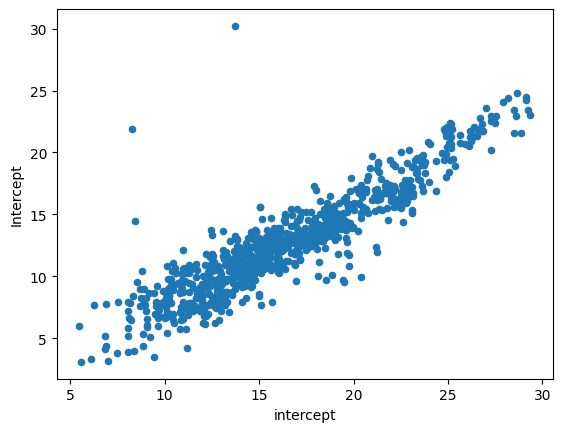

In [22]:
coefs[coefs["Intercept"] > 0].plot.scatter(x="intercept", y="Intercept")

## PCA

In [73]:
co_norm = (coefs - coefs.mean()) / coefs.std()
co_norm.iloc[:, :10]

,,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef
id,,,,,,,,,,,
01010000,0,-0.943126,1.020460,-0.239062,-1.207480,-1.574790,1.057523,1.185340,2.035952,-0.495313,0.335223
01011000,0,-0.874865,1.046572,-0.303112,-1.222831,-1.574790,-0.790702,1.723365,1.467359,-0.592296,0.137413
01018035,0,-0.762433,1.146347,-0.367163,-1.192130,-1.574790,-0.675188,1.043375,1.274206,-0.305630,0.431983
01038000,0,-0.379418,1.302420,-0.495264,-1.222831,0.691799,-1.021730,0.162987,0.618842,-0.218354,0.366795
010642505,0,-0.941962,0.135945,-0.367163,-1.253531,-1.482276,0.884252,0.976034,-0.397956,-0.516314,0.444743
...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,0,-1.170092,0.138135,-1.712223,0.619173,-0.510881,-0.963973,1.273442,0.014126,0.466665,-0.691027
394220106431500,0,-1.212328,-0.559231,-0.175011,0.527073,0.090459,1.115280,1.967705,0.632957,-0.344901,-0.445304
402114105350101,0,-1.769430,-0.565924,-1.648173,0.649873,-0.048312,1.115280,1.659354,-0.448210,0.022142,-0.365879


There are some nontrivial cross-correlations, so let's see what the principal component axes look like.  Let's limit it to stream properties (10 variables).

In [74]:
pca = PCA()
fit = pca.fit(co_norm.iloc[:, :10])
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.28635317 0.19484294 0.16747634 0.07725998 0.07444256 0.05951356
 0.0512307  0.0416597  0.03223543 0.01498563]
[0.28635317 0.48119611 0.64867245 0.72593242 0.80037498 0.85988854
 0.91111925 0.95277894 0.98501437 1.        ]


Compared to 10 coefficients, we can capture ~95% of the variance with 8 components.  6 components capture 86%.  Doesn't really seem worth pursuing.

<Axes: >

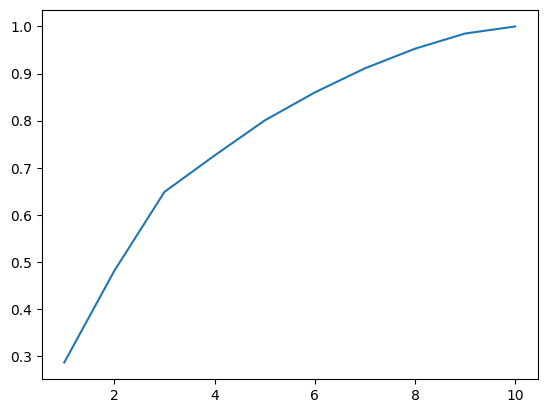

In [75]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

## Coefficient Correlations

### Geography

What's predictable from linear XYZ (plus squared longitude, which gives access to "coasts vs middle")?

In [98]:
coef_xyz = coefs.merge(data[["lat", "lon", "elev", "id"]].groupby("id").mean(), on="id").assign(lon2 = lambda x: (x["lon"] - x["lon"].mean())**2)
coef_xyz

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp,lat,lon,elev,lon2
id,,,,,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.275727,0.001378,8.787829,-6.067253,-15.167896,693.766616,-266.789732,-570.140506,46.700556,-69.715556,421.54080,575.889748
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.255334,0.001096,9.763696,-5.932321,-14.604735,699.838476,-263.185827,-560.410490,47.069722,-69.079444,362.70602,606.824801
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.315614,0.001516,11.344458,-5.606314,-14.288229,766.456060,-289.078520,-584.337550,46.181111,-67.803889,175.52219,671.295438
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.333966,0.001423,12.411499,-5.377854,-12.851322,880.149454,-319.869872,-646.207066,44.222778,-69.593889,109.47253,581.743994
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.271311,0.001534,10.084860,-5.104671,-12.878405,718.774950,-241.243771,-548.664202,44.083889,-71.285556,704.23030,503.001861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.478011,-0.000085,11.893447,-4.284127,-11.356781,574.381380,-190.504921,-319.363068,38.988361,-107.348489,2647.72120,185.919506
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.307356,0.000265,9.466164,-3.972916,-10.774711,516.589866,-135.047240,-276.552819,39.705000,-106.725833,3027.49410,169.327101
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.384537,0.000378,6.876817,-4.462743,-11.078878,476.261802,-147.476692,-304.520152,40.353861,-105.584139,3229.42850,140.917800


Intercept, Amplitude, SpringSummer, and air temperature variation are partially explained by XYZ, while mean air temperature and all of humidity are quite well explained.  Seasonality dates are very poorly explained.

In [99]:
coef_xyz.corr()[["lat", "lon", "elev", "lon2"]]**2

,lat,lon,elev,lon2
Intercept,0.434484,0.062616,0.170895,0.093716
Amplitude,0.000220,0.244220,0.061939,0.256083
FallDay,0.040251,0.000045,0.009747,0.024269
WinterDay,0.153067,0.048174,0.016780,0.087998
SpringDay,0.167345,0.007364,0.020012,0.022196
SummerDay,0.030443,0.001409,0.002904,0.000012
SpringSummer,0.178378,0.173442,0.234462,0.108312
FallWinter,0.002045,0.010155,0.021177,0.047704
at_coef,0.089587,0.057666,0.034808,0.094770
vp_coef,0.000768,0.028166,0.023897,0.002728


# Stationary Model

For preliminary prototyping, we'll use a GAM and see if we can pull some bits out later.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).  For now, we'll just make a "big model of all the variables", one at a time.

For the stationary model, weather summaries are predictors, not dependent variables.

A fundamental observation: it seems like improvements in the GAM are dominated by threshold behaviors, which is causing it to struggle to achieve good performance.  Possibly a different approach to prototyping would be in order.

## Generalized Code

In [22]:
data.columns

Index(['id', 'date', 'temperature', 'prcp', 'srad', 'swe', 'tmax', 'tmin',
       'vp', 'day', 'water', 'developed', 'barren', 'forest', 'shrubland',
       'herbaceous', 'cultivated', 'wetland', 'ice_snow', 'area', 'elev',
       'elev_min', 'elev_std', 'slope', 'asp_north', 'asp_east', 'lat', 'lon'],
      dtype='object')

In [27]:
def ssn_df(data):
    ctr, I = analysis.circular_season(data["date"], data["prcp"])
    return pd.DataFrame({"ssn_phi": [ctr], "ssn_index": I})

data["frozen"] = data["tmax"] < 0    
data["cold_prcp"] = data["prcp"] * data["frozen"]
predictors = data.groupby("id", as_index=False)[["prcp", "cold_prcp", "frozen", "srad", "water", "developed", "barren", "forest", "shrubland", "herbaceous", "cultivated", "wetland", "ice_snow", "area",
                                                 "elev", "elev_min", "slope", "asp_north", "asp_east", "lat", "lon"]].mean().merge(
    data.groupby("id", as_index=False)[["prcp", "srad", "vp"]].std(),
    on="id", suffixes=["", "_sd"]).merge(
        data.groupby("id").apply(ssn_df, include_groups=False),
        on="id")
# pmonthlies = data.assign(month = lambda x: x["date"].dt.month).groupby(["id", "month"])[["prcp", "srad", "tmax", "vp"]].mean().unstack(1)
# pmonthlies.columns = [f"{x[0]}_{x[1]}" for x in pmonthlies.columns]
pds = coefs.drop(columns=
                 # ["threshold_act_min", "threshold_act_cutoff", "threshold_coef_min", "threshold_coef_max"]
                 ["at_coef", "threshold_act_min"]
                ).merge(predictors, on="id").\
    assign(tamp = lambda x: np.sqrt(x["ksin"]**2 + x["kcos"]**2))
pds["atmax"] = pds["intercept"] + pds["tamp"]
pds["atmin"] = pds["intercept"] - pds["tamp"]
pds = pds[pds["Intercept"] > 0]  # filter one erroneous site
allvar = pds.columns[12:]
# pds["vpmax"] = pds["intercept_vp"] + pds["hamp"]
# pds["vpmin"] = pds["intercept_vp"] - pds["hamp"]
Xpd = pds.iloc[:, 12:]
cols = Xpd.columns
Xall = Xpd.to_numpy()
# Xmo = pds.merge(pmonthlies, on="id").dropna()
# Xpdmo = Xmo.loc[:, 'intercept':]

In [24]:
pds

,id,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,threshold_coef_min,...,lat,lon,prcp_sd,srad_sd,vp,ssn_phi,ssn_index,tamp,atmax,atmin
0,01010000,6.788488,14.311346,312.0,20.0,120.0,239.0,0.755547,1.283051,-1.827897,...,46.700556,-69.715556,6.315056,149.450027,430.352665,216.270692,0.540514,14.217668,24.401369,-4.033967
1,01011000,8.502618,11.862606,322.0,27.0,120.0,204.0,2.402533,2.684005,0.031658,...,47.069722,-69.079444,6.561087,153.458731,455.495238,222.829319,0.382964,15.058433,25.240942,-4.875925
2,01018035,9.134936,11.933740,316.0,28.0,120.0,206.0,1.840423,2.499253,0.126304,...,46.181111,-67.803889,6.995276,142.039525,495.077296,229.682793,0.285843,14.443800,26.340904,-2.546696
3,01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.113039,...,44.222778,-69.593889,8.565124,133.166733,555.611033,239.809530,0.084350,13.931181,26.342680,-1.519682
4,010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.162370,...,44.083889,-71.285556,8.663051,139.969164,474.622220,262.186041,0.141414,13.853194,23.938054,-3.768334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,-0.019589,...,38.988361,-107.348489,3.545819,113.087312,243.660423,186.241206,0.500117,12.137966,24.031413,-0.244519
919,394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.083988,...,39.705000,-106.725833,3.349789,147.347364,252.754076,47.872008,0.122565,11.483834,20.949998,-2.017670
920,402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,-0.007609,...,40.353861,-105.584139,4.648200,155.307238,220.697633,172.126836,0.346147,11.943937,18.820754,-5.067119
921,404417108524900,9.623788,8.047868,330.0,75.0,157.0,204.0,1.818095,0.949920,-1.000000,...,40.738056,-108.880278,2.215789,125.916954,262.787681,220.626578,0.094023,14.719822,31.648512,2.208867


In [25]:
# Reference linear model
X = np.concatenate((np.ones((len(Xpd), 1)), Xpd.to_numpy()), axis=1)
# y = pds.iloc[:, 1:12]
y = pds.iloc[:, 1:12]  # 12
fit = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ fit
pd.concat([
    pd.DataFrame({"R2": np.corrcoef(y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[y.columns[i]])
    for i in range(len(y.columns))
])

,R2
Intercept,0.871436
Amplitude,0.566061
FallDay,0.241498
WinterDay,0.399676
SpringDay,0.291344
SummerDay,0.216076
SpringSummer,0.488180
FallWinter,0.332224
threshold_coef_min,0.184354
threshold_act_cutoff,0.109064


So, that one site (one site!) with a very negative Intercept was seriously screwing things up.  Linear R2 for Intercept is now 0.88, roughly as expected.  That holds similarly if we exclude the monthly data.

Adding aspect values and seasonality indices, our reference linear model is doing *awesome* compared to TempEst 2, with R2s of intercept 0.87 (vs 0.9), amplitude 0.71 (vs 0.65), SpringSummer 0.59 (0.48), FallWinter 0.45 (0.43), WinterDay 0.40 (0.38), SpringDay 0.29, SummerDay 0.22, FallDay 0.24, threshold_coef_min 0.19, threshold_act_cutoff 0.11, threshold_coef_max 0.27 (but those three can use seasonality predictors).  The latter six were not used or not predicted by TempEst 2.

In [120]:
def scatterplots(yv, data=pds, skip=12):
    xv = data.columns[skip:]
    nt = len(xv)
    Ny = 4
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    fig, axes = plt.subplots(Ny, Nx, figsize=(12,10))
    fig.tight_layout()
    for i, term in enumerate(xv):
        ax = axes[i // Nx, i % Nx]
        data.plot.scatter(x=term, y=yv, ax=ax)

def focused_scatters(yv, xv, data=pds):
    sns.pairplot(data, vars=xv+[yv])

def pdps(gam, xy0=True, names=None, ylab=None, save=None):
    nt = len(gam.terms) - 1
    Ny = 1 if nt < 3 else (2 if nt < 9 else 3)
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx] if Ny > 1 else axes[i]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_xlabel(repr(term) if names is None else names[i])
        if ylab is not None and i % Nx == 0:
            ax.set_ylabel(ylab)
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)

def get_pd(gam, n):
    XX = gam.generate_X_grid(term=n)
    y = gam.partial_dependence(term=n, X=XX)
    return (XX[:,n], y)


In [309]:
varname = {
    'intercept': "Mean Air Temperature (C)",
     'prcp': "Mean Precipitation (mm/day)",
     'cold_prcp': "Mean Subfreezing Precip (mm/day)",
     'frozen': "Proportion of Days Below Freezing",
     'srad': "Mean Solar Radiation (W/m2)",
     'water': "Water Land Cover Fraction",
     'developed': "Developed Land Cover Fraction",
     'barren': "Barren Land Cover Fraction",
     'forest': "Forest Land Cover Fraction",
     'shrubland': "Shrubland Land Cover Fraction",
     'herbaceous': "Herbaceous Land Cover Fraction",
     'cultivated': "Cultivated Land Cover Fraction",
     'wetland': "Wetland Land Cover Fraction",
     'ice_snow': "Ice/Snow Land Cover Fraction",
     'area': "Watershed Area (km2)",
     'elev': "Mean Elevation (m)",
     'elev_min': "Min Elevation (m)",
     'slope': "Watershed Mean Slope (m/m)",
     'asp_north': "Slope Aspect Mean North Component",
     'asp_east': "Slope Aspect Mean East Component",
     'lat': "Latitude (deg N)",
     'lon': "Longitude (deg E)",
     'prcp_sd': "Std Dev Precipitation (mm/day)",
     'srad_sd': "Std Dev Solar Radiation (W/m2)",
     'vp': "Std Dev Vapor Pressure (Pa)",
     'ssn_phi': "Mean Date of Precip (Julian day)",
     'ssn_index': "Precip Seasonality Index",
     'tamp': "Annual Air Temperature Amplitude (C)",
     'atmax': "Max Air Temperature (C)",
     'atmin': "Min Air Temperature (C)",
     "Intercept": "3S Intercept (C)",
     "Amplitude": "3S Amplitude (C)"
}
rename = lambda vrs: [varname[v] for v in vrs]

## Intercept

In [94]:
var_itx = ['intercept', 'cold_prcp', 'frozen',
       'area', 'elev_min']
eq_itx = sum([s(i) for i in range(1, len(var_itx))], start=s(0)) # l(0) + s(1)
lam_itx = 10 # 100
gam_itx = LinearGAM(eq_itx, lam=lam_itx).fit(pds[var_itx], pds["Intercept"])
gam_itx.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     32.5778
Link Function:                     IdentityLink Log Likelihood:                                 -1681.8144
Number of Samples:                          923 AIC:                                             3430.7844
                                                AICc:                                            3433.3981
                                                GCV:                                                2.0488
                                                Scale:                                               1.919
                                                Pseudo R-Squared:                                    0.884
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\27490146.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_itx.summary()


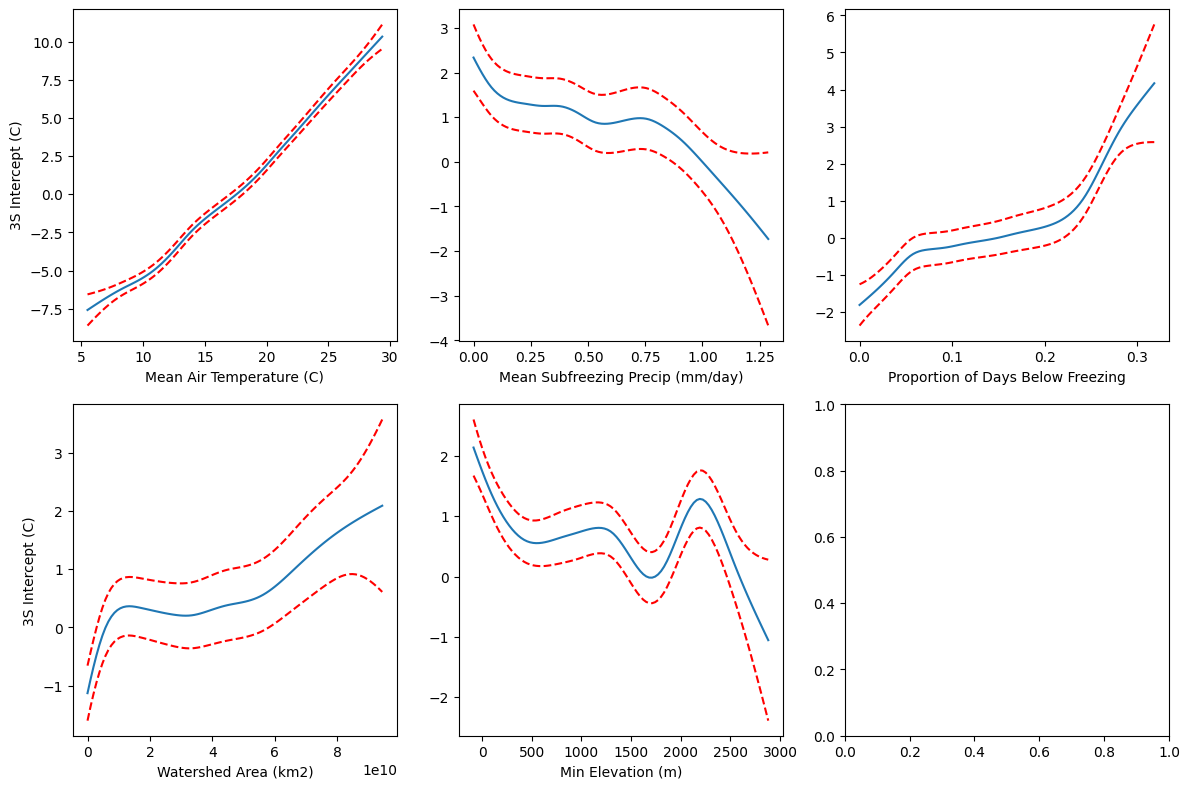

In [193]:
pdps(gam_itx, False, rename(var_itx), "3S Intercept (C)", "results/PDPs/InterceptGAM.png")

## Amplitude

In [139]:
var_amp = ['frozen',
       'water', 'forest', 'area', 'elev', 'elev_min',
       'prcp_sd',
       'vp', 'ssn_phi', 'tamp']
eq_amp = sum([s(i) for i in range(1, len(var_amp))], start=s(0)) #s(0) + s(1) + s(2)
lam_amp = 50
gam_amp = LinearGAM(eq_amp, lam=lam_amp).fit(pds[var_amp], pds["Amplitude"])
gam_amp.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     46.2912
Link Function:                     IdentityLink Log Likelihood:                                 -2013.7456
Number of Samples:                          923 AIC:                                             4122.0737
                                                AICc:                                            4127.2954
                                                GCV:                                                3.3193
                                                Scale:                                               3.021
                                                Pseudo R-Squared:                                    0.613
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\188328297.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_amp.summary()


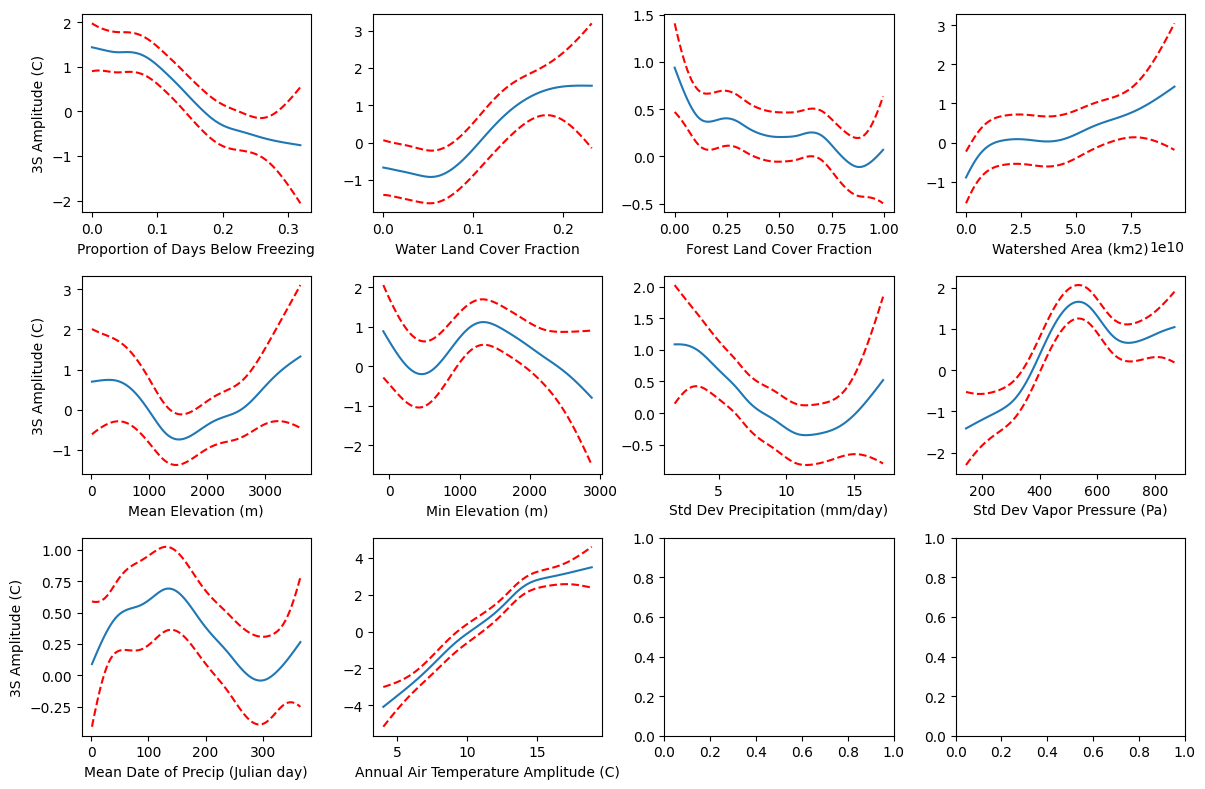

In [194]:
pdps(gam_amp, False, rename(var_amp),
     "3S Amplitude (C)", "results/PDPs/AmplitudeGAM.png")

## SpringSummer

In [164]:
var_ssu = ['intercept', 'prcp', 'cold_prcp', 'frozen',
       'water', 'elev', 'elev_min',
       'prcp_sd', 'srad_sd', 'vp'] # ["intercept", "vp", "frozen", "forest"]
eq_ssu = sum([s(i) for i in range(1, len(var_ssu))], start=s(0))
lam_ssu = 10
gam_ssu = LinearGAM(eq_ssu, lam=lam_ssu).fit(pds[var_ssu], pds["SpringSummer"])
gam_ssu.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     62.8337
Link Function:                     IdentityLink Log Likelihood:                                   -1069.32
Number of Samples:                          923 AIC:                                             2266.3073
                                                AICc:                                            2275.9524
                                                GCV:                                                  0.49
                                                Scale:                                              0.4304
                                                Pseudo R-Squared:                                   0.5591
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\4282211634.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_ssu.summary()


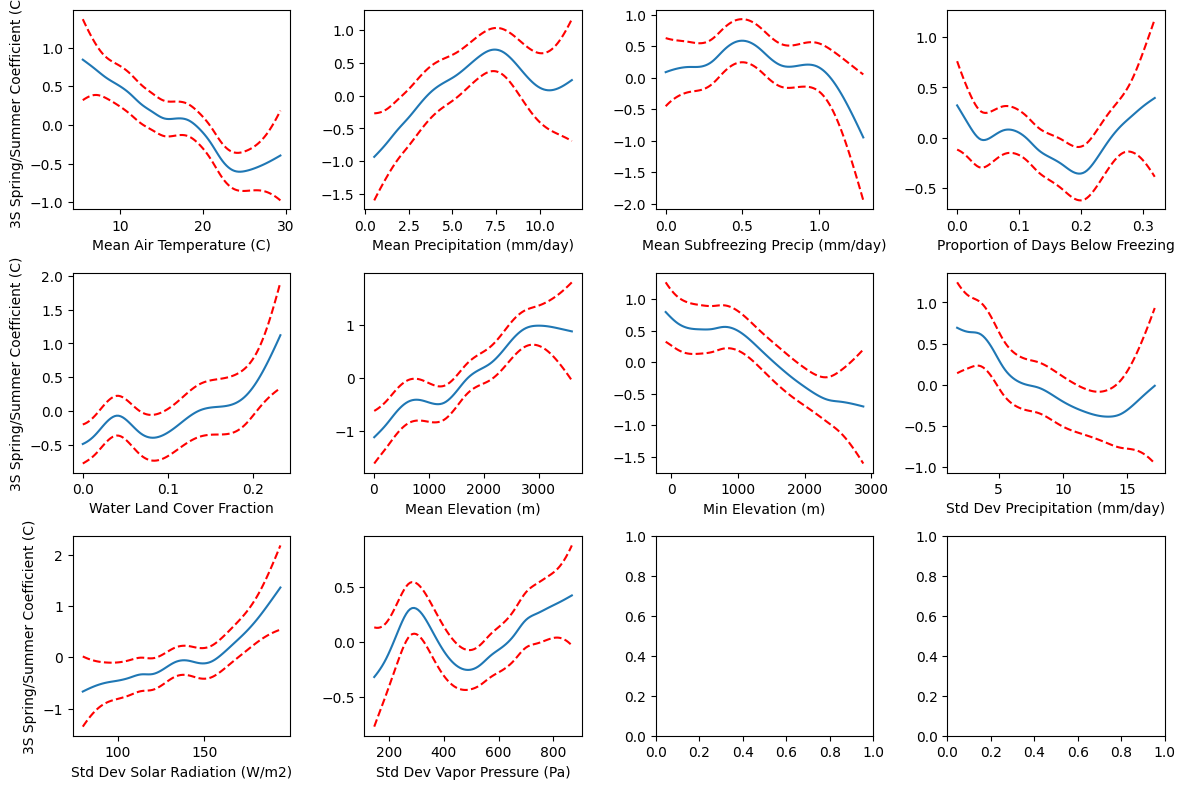

In [195]:
pdps(gam_ssu, False, rename(var_ssu), "3S Spring/Summer Coefficient (C)", "results/PDPs/SpringSummerGAM.png")

## FallWinter

In [185]:
var_fw = ['intercept', 'frozen', 'srad',
       'water', 'forest', 'elev',
       'slope', 'lat', 'lon',
       'vp', 'ssn_phi', 'ssn_index', 'tamp']
eq_fw = sum([s(i) for i in range(1, len(var_fw))], start=s(0))
lam_fw = 10
gam_fw = LinearGAM(eq_fw, lam=lam_fw).fit(pds[var_fw], pds["FallWinter"])
gam_fw.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     83.7967
Link Function:                     IdentityLink Log Likelihood:                                 -1043.6095
Number of Samples:                          923 AIC:                                             2256.8124
                                                AICc:                                            2274.1923
                                                GCV:                                                0.5483
                                                Scale:                                              0.4595
                                                Pseudo R-Squared:                                   0.4994
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\2785100277.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_fw.summary()


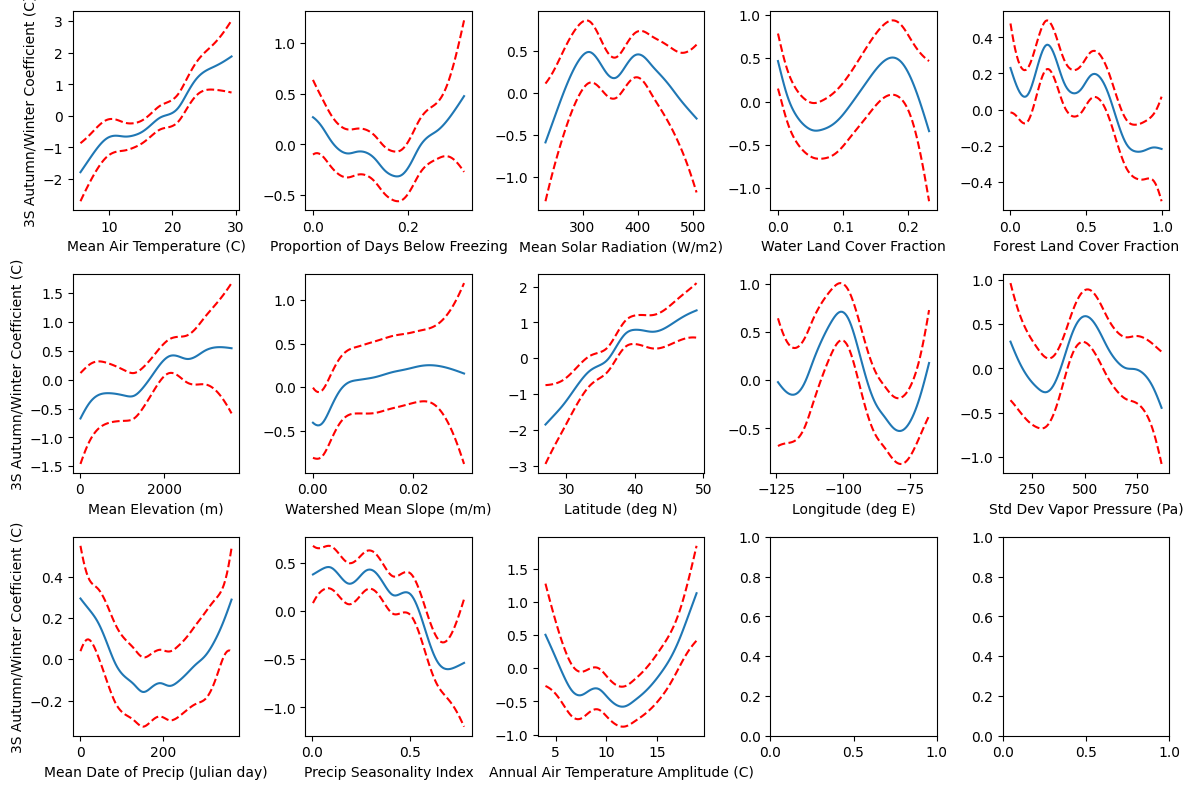

In [197]:
pdps(gam_fw, False, rename(var_fw),
     "3S Autumn/Winter Coefficient (C)", "results/PDPs/FallWinterGAM.png")

## SpringDay

In [225]:
var_spd = ['intercept', 'elev',
       'lat', 'lon',
       'ssn_phi', 'ssn_index', 'tamp']
eq_spd = sum([s(i) for i in range(1, len(var_spd))], start=s(0))
lam_spd = 10
gam_spd = LinearGAM(eq_spd, lam=lam_spd).fit(pds[var_spd], pds["SpringDay"])
gam_spd.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.8262
Link Function:                     IdentityLink Log Likelihood:                                 -6177.3076
Number of Samples:                          923 AIC:                                            12454.2676
                                                AICc:                                           12460.0749
                                                GCV:                                               354.876
                                                Scale:                                            321.2528
                                                Pseudo R-Squared:                                    0.351
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\3937806819.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_spd.summary()


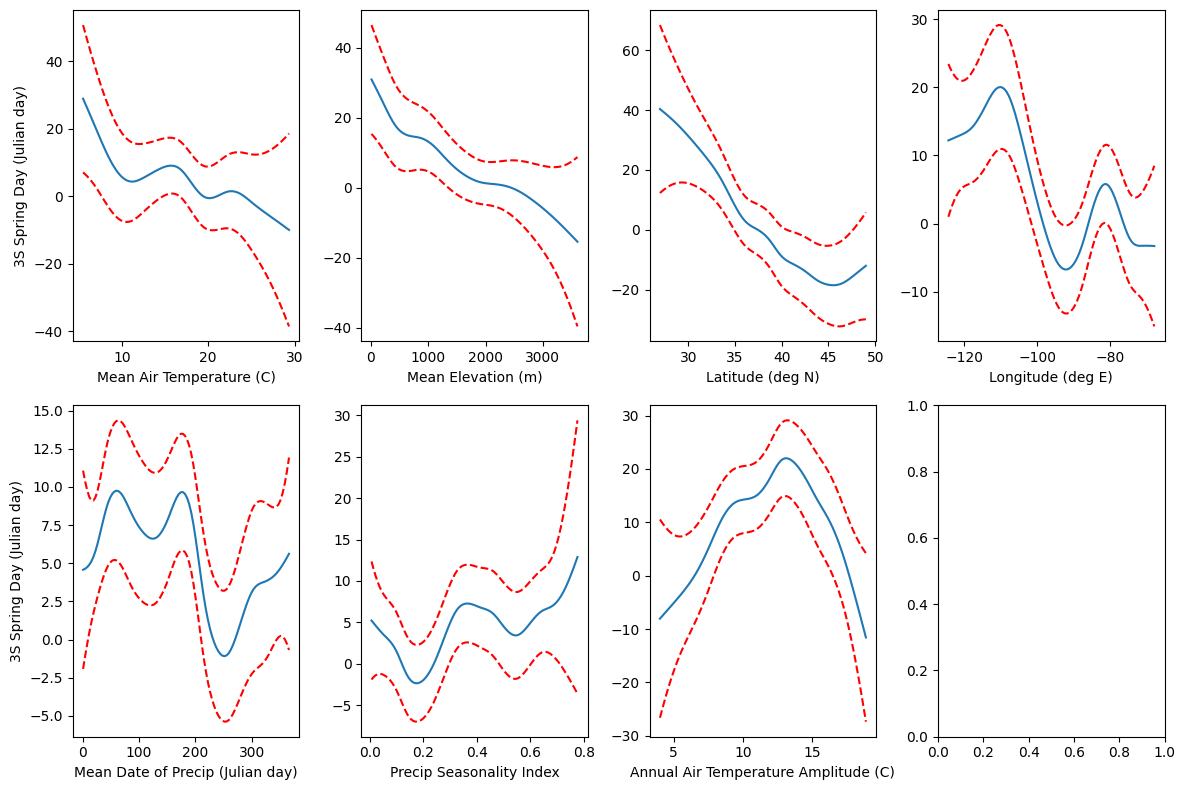

In [227]:
pdps(gam_spd, False, rename(var_spd), "3S Spring Day (Julian day)", "results/PDPs/SpringDayGAM.png")

## SummerDay

In [249]:
var_sud = ['prcp', 'cold_prcp', 'frozen',
       'wetland', 'ice_snow', 'elev',
       'lat', 'lon', 'prcp_sd', 'srad_sd',
       'vp', 'ssn_index', 'tamp']
eq_sud = sum([s(i) for i in range(1, len(var_sud))], start=s(0))
lam_sud = 10
gam_sud = LinearGAM(eq_sud, lam=lam_sud).fit(pds[var_sud], pds["SummerDay"])
gam_sud.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     79.5796
Link Function:                     IdentityLink Log Likelihood:                                 -5854.6115
Number of Samples:                          923 AIC:                                            11870.3824
                                                AICc:                                           11886.0075
                                                GCV:                                              267.5149
                                                Scale:                                            226.3466
                                                Pseudo R-Squared:                                   0.3094
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\1339153491.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_sud.summary()


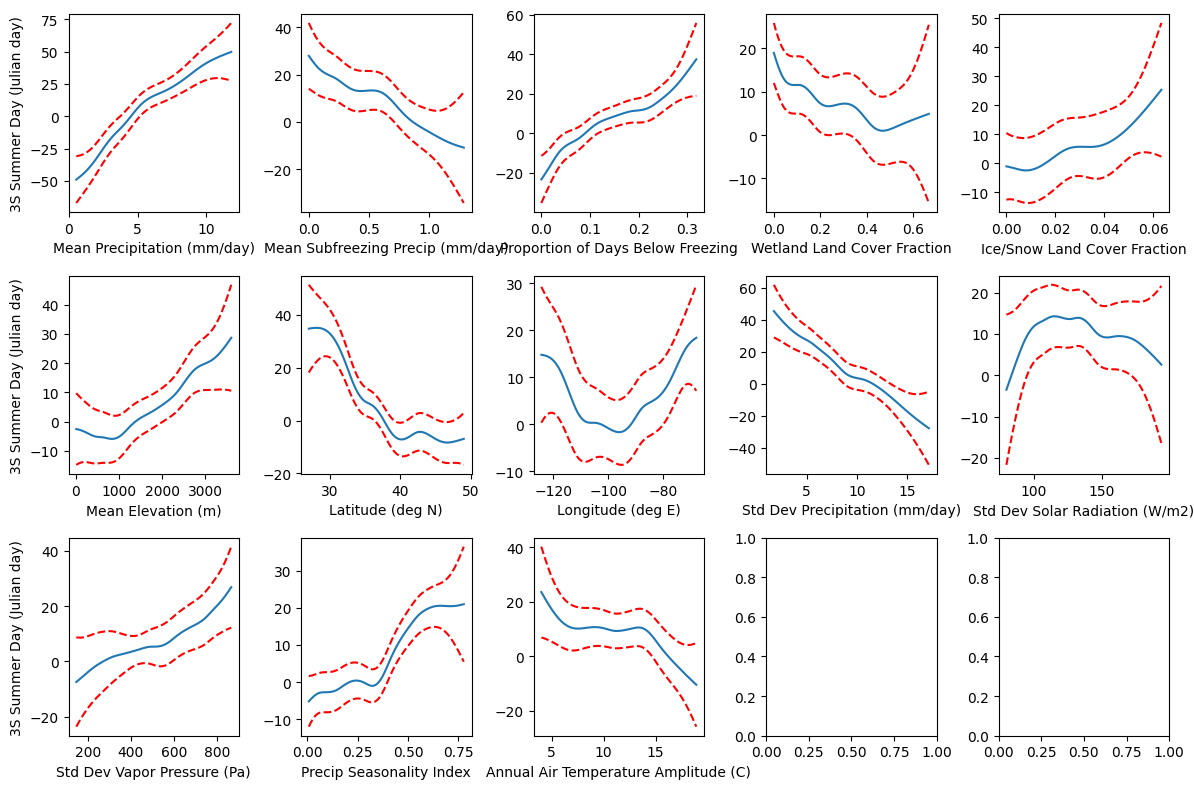

In [250]:
pdps(gam_sud, False, rename(var_sud), "3S Summer Day (Julian day)", "results/PDPs/SummerDayGAM.png")

## FallDay

In [354]:
var_fad = ['srad',
       'water', 'developed', 'forest',
       'wetland', 'ice_snow', 'elev_min',
       'lat', 'lon']
eq_fad = sum([s(i) for i in range(1, len(var_fad))], start=s(0))
lam_fad = 10
gam_fad = LinearGAM(eq_fad, lam=lam_fad).fit(pds[var_fad], pds["FallDay"])
gam_fad.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     56.2541
Link Function:                     IdentityLink Log Likelihood:                                 -5560.2758
Number of Samples:                          923 AIC:                                            11235.0597
                                                AICc:                                           11242.7736
                                                GCV:                                              184.5335
                                                Scale:                                            164.4061
                                                Pseudo R-Squared:                                   0.3612
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\1903787715.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_fad.summary()


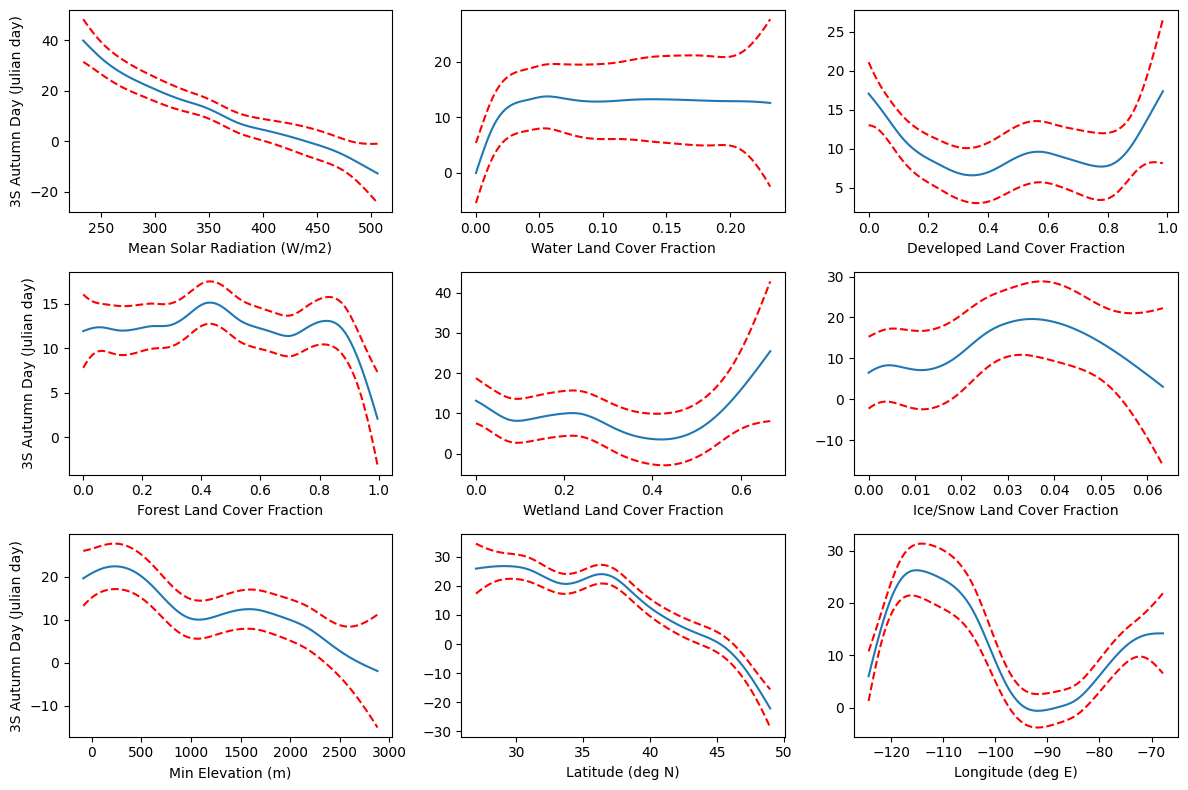

In [278]:
pdps(gam_fad, False, rename(var_fad),
     "3S Autumn Day (Julian day)", "results/PDPs/FallDayGAM.png")

## WinterDay

In [302]:
var_wid = ['frozen', 'water', 'forest', 'wetland', 'srad_sd', 'tamp']
eq_wid = sum([s(i) for i in range(len(var_wid))], start=s(0))
lam_wid = 10
gam_wid = LinearGAM(eq_wid, lam=lam_wid).fit(pds[var_wid], pds["WinterDay"])
gam_wid.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     39.3893
Link Function:                     IdentityLink Log Likelihood:                                 -6785.5519
Number of Samples:                          923 AIC:                                            13651.8824
                                                AICc:                                           13655.6747
                                                GCV:                                              672.8449
                                                Scale:                                            621.3648
                                                Pseudo R-Squared:                                   0.4412
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\908341900.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_wid.summary()


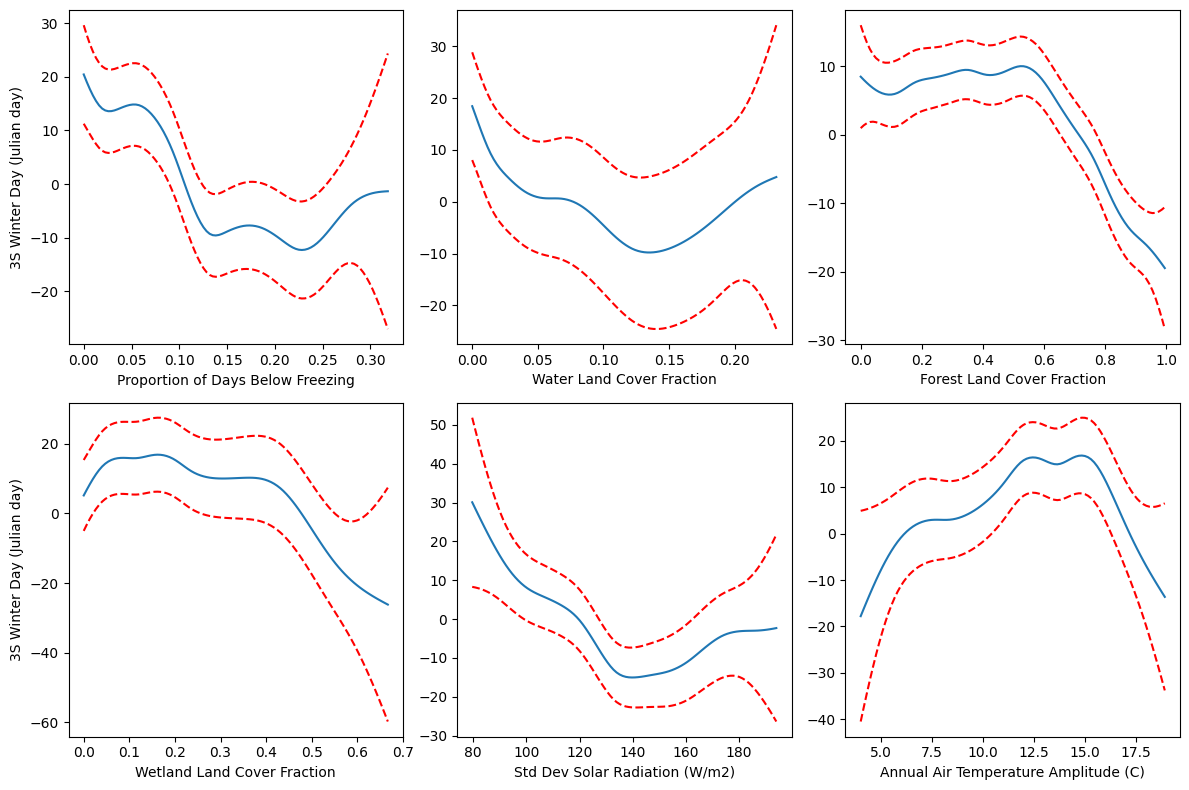

In [304]:
pdps(gam_wid, False, rename(var_wid),
    "3S Winter Day (Julian day)", "results/PDPs/WinterDayGAM.png")

## Max Sensitivity

intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.

In [338]:
# intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.
# var_tcmax = ["Intercept", "Amplitude", "intercept", "atmax", "water", "vp"]
var_tcmax = ["Intercept", 'intercept', 'frozen', 'srad',
       'water', 'area',
       'lat', 'lon', 'ssn_index']
eq_tcmax = sum([s(i) for i in range(1, len(var_tcmax))], start=s(0))
lam_tcmax = 10
gam_tcmax = LinearGAM(eq_tcmax, lam=lam_tcmax).fit(pds[var_tcmax], pds["threshold_coef_max"])
gam_tcmax.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     57.9024
Link Function:                     IdentityLink Log Likelihood:                                 -5264.5632
Number of Samples:                          923 AIC:                                            10646.9312
                                                AICc:                                           10655.1073
                                                GCV:                                                0.0698
                                                Scale:                                              0.0619
                                                Pseudo R-Squared:                                   0.3845
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\1650920775.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tcmax.summary()


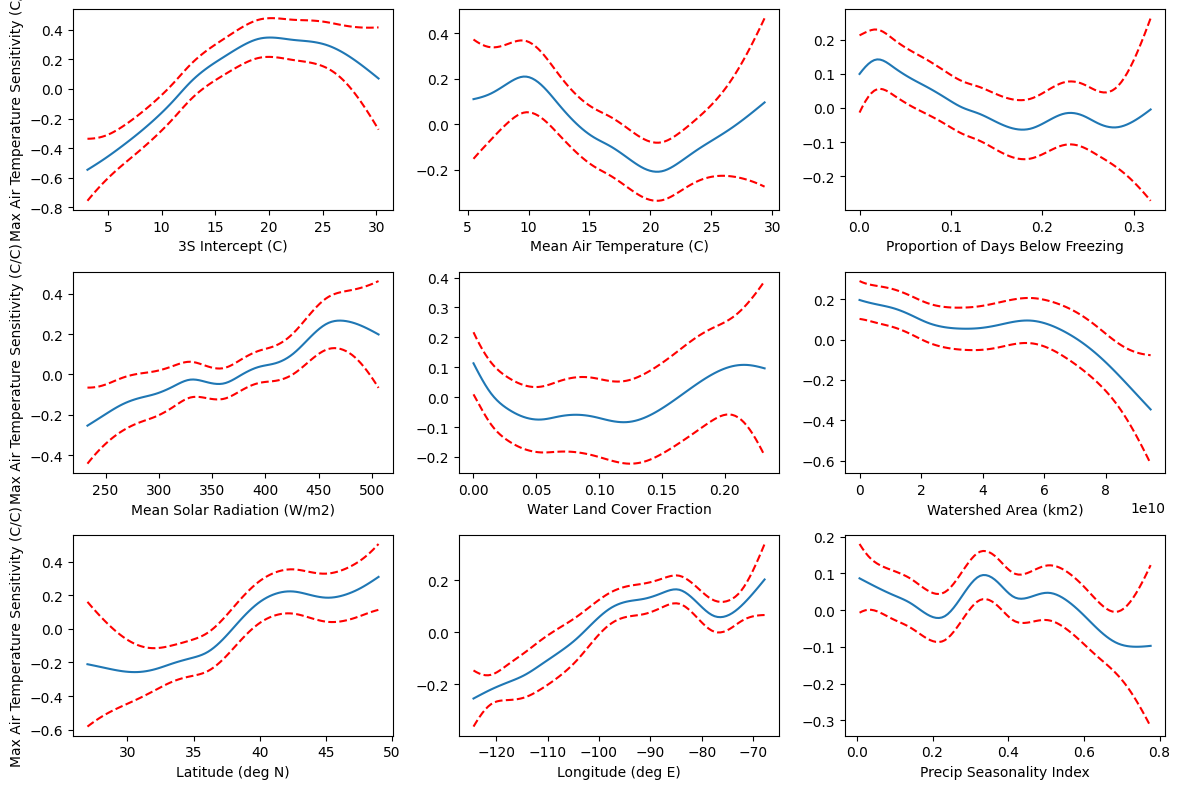

In [340]:
pdps(gam_tcmax, False, rename(var_tcmax),
    "Max Air Temperature Sensitivity (C/C)", "results/PDPs/TCMaxGAM.png")

## Min Sensitivity

In [355]:
# intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.
# var_tcmin = ["atmin", "srad_sd", "vp", "ssn_index"]
var_tcmin = ['intercept', 'frozen', 'srad',
       'elev', 'tamp']
eq_tcmin = sum([s(i) for i in range(1, len(var_tcmin))], s(0))
lam_tcmin = 10
gam_tcmin = LinearGAM(eq_tcmin, lam=lam_tcmin).fit(pds[pds["threshold_coef_min"] > -1][var_tcmin], pds[pds["threshold_coef_min"] > -1]["threshold_coef_min"])
gam_tcmin.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.8359
Link Function:                     IdentityLink Log Likelihood:                                -11299.4957
Number of Samples:                          605 AIC:                                            22664.6634
                                                AICc:                                           22668.5538
                                                GCV:                                                0.0242
                                                Scale:                                               0.022
                                                Pseudo R-Squared:                                   0.5877
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\2460864100.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tcmin.summary()


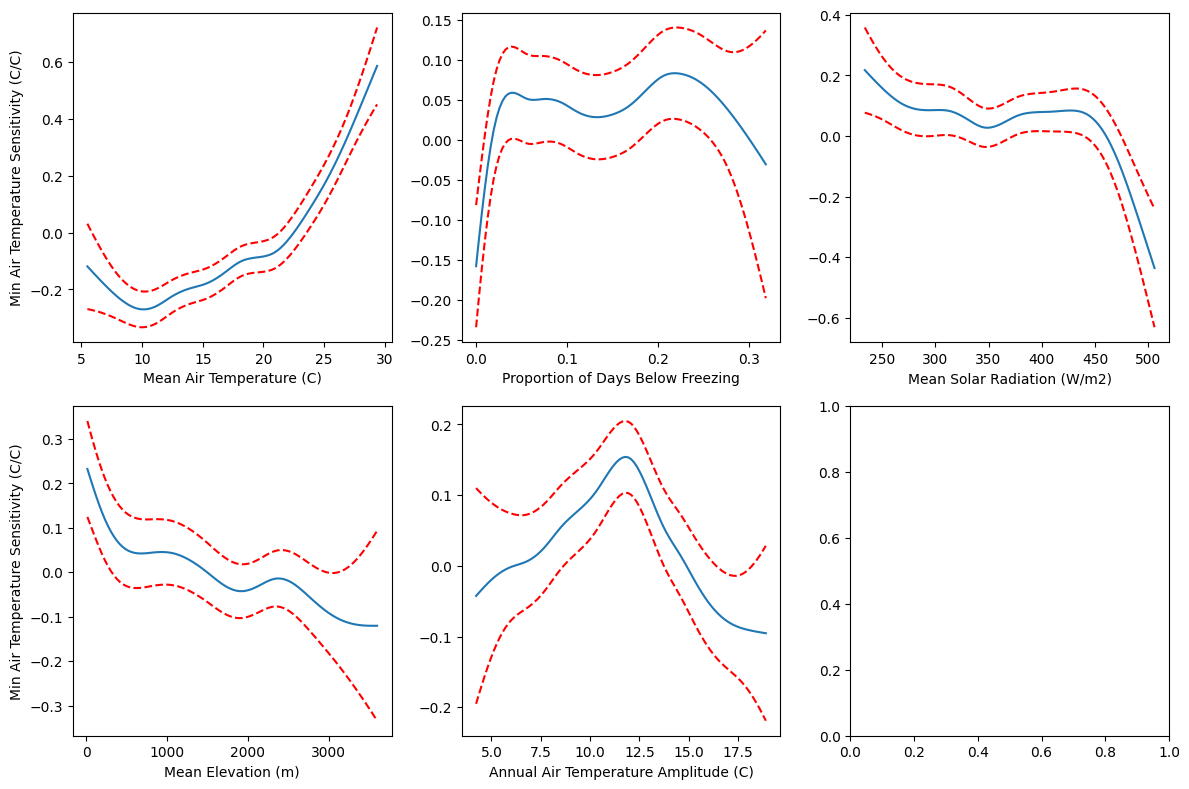

In [356]:
pdps(gam_tcmin, False, rename(var_tcmin),
    "Min Air Temperature Sensitivity (C/C)", "results/PDPs/TCMinGAM.png")

## Sensitivity Cutoff

In [372]:
# intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.
# var_tcc = ["frozen", "ssn_phi", "ssn_index", "vp", "srad_sd"]
var_tcc = ['frozen',
    'elev_min',
       'lat', 'lon', 'srad_sd']
eq_tcc = sum([s(i) for i in range(1, len(var_tcc))], s(0))
lam_tcc = 10
gam_tcc = LinearGAM(eq_tcc, lam=lam_tcc).fit(pds[pds["threshold_coef_min"] > -1][var_tcc], pds[pds["threshold_coef_min"] > -1]["threshold_act_cutoff"])
gam_tcc.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     32.2295
Link Function:                     IdentityLink Log Likelihood:                                 -2526.7413
Number of Samples:                          605 AIC:                                             5119.9416
                                                AICc:                                            5123.9272
                                                GCV:                                               28.1968
                                                Scale:                                             25.5065
                                                Pseudo R-Squared:                                   0.4976
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_20356\3342009018.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tcc.summary()


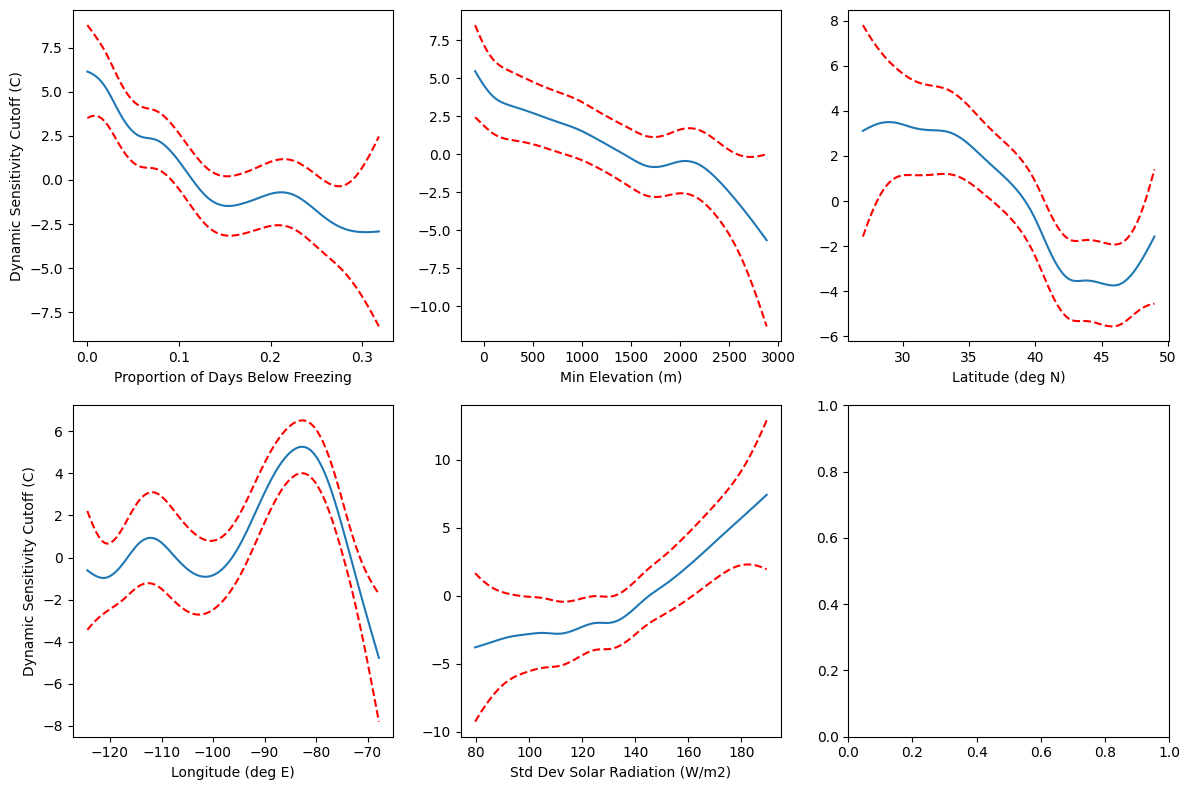

In [374]:
pdps(gam_tcc, False, rename(var_tcc),
     "Dynamic Sensitivity Cutoff (C)", "results/PDPs/TCCutoffGAM.png")

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  First, we'll go fine-tune the GAMs.

## New GAMs

In [375]:
# Run this to build list...
print("var_sets = [")
for (vr, nm) in [("itx", "Intercept"), ("amp", "Amplitude"), ("ssu", "SpringSummer"),
                 ("fw", "FallWinter"), ("spd", "SpringDay"), ("sud", "SummerDay"),
                 ("fad", "FallDay"), ("wid", "WinterDay"),
                 # ("atc", "at_coef")
                 ("tcmax", "threshold_coef_max"), ("tcmin", "threshold_coef_min"), ("tcc", "threshold_act_cutoff")
                ]:
    vrs = eval("var_" + vr)
    eq = eval("eq_" + vr)
    lam = eval("lam_" + vr)
    print(f'    {{"name": "{nm}", "vars": {vrs}, "eq": {eq}, "lam": {lam}}},')
    # print(f"var_{vr} = {eval('var_' + vr)}")
    # print(f"eq_{vr} = {eval('eq_' + vr)}")
    # print(f"lam_{vr} = {eval('lam_' + vr)}")
print("]")

var_sets = [
    {"name": "Intercept", "vars": ['intercept', 'cold_prcp', 'frozen', 'area', 'elev_min'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
    {"name": "Amplitude", "vars": ['frozen', 'water', 'forest', 'area', 'elev', 'elev_min', 'prcp_sd', 'vp', 'ssn_phi', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 50},
    {"name": "SpringSummer", "vars": ['intercept', 'prcp', 'cold_prcp', 'frozen', 'water', 'elev', 'elev_min', 'prcp_sd', 'srad_sd', 'vp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 10},
    {"name": "FallWinter", "vars": ['intercept', 'frozen', 'srad', 'water', 'forest', 'elev', 'slope', 'lat', 'lon', 'vp', 'ssn_phi', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 10},
    {"name": "SpringDay", "vars": ['intercept', 'elev', 'lat', 'lon', 'ssn_phi', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3

In [2]:
var_sets = [
    {"name": "Intercept", "vars": ['intercept', 'cold_prcp', 'frozen', 'area', 'elev_min'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
    {"name": "Amplitude", "vars": ['frozen', 'water', 'forest', 'area', 'elev', 'elev_min', 'prcp_sd', 'vp', 'ssn_phi', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 50},
    {"name": "SpringSummer", "vars": ['intercept', 'prcp', 'cold_prcp', 'frozen', 'water', 'elev', 'elev_min', 'prcp_sd', 'srad_sd', 'vp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 10},
    {"name": "FallWinter", "vars": ['intercept', 'frozen', 'srad', 'water', 'forest', 'elev', 'slope', 'lat', 'lon', 'vp', 'ssn_phi', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 10},
    {"name": "SpringDay", "vars": ['intercept', 'elev', 'lat', 'lon', 'ssn_phi', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6), "lam": 10},
    {"name": "SummerDay", "vars": ['prcp', 'cold_prcp', 'frozen', 'wetland', 'ice_snow', 'elev', 'lat', 'lon', 'prcp_sd', 'srad_sd', 'vp', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 10},
    {"name": "FallDay", "vars": ['srad', 'water', 'developed', 'forest', 'wetland', 'ice_snow', 'elev_min', 'lat', 'lon'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8), "lam": 10},
    {"name": "WinterDay", "vars": ['frozen', 'water', 'forest', 'wetland', 'srad_sd', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5), "lam": 10},
    {"name": "threshold_coef_max", "vars": ['Intercept', 'intercept', 'frozen', 'srad', 'water', 'area', 'lat', 'lon', 'ssn_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8), "lam": 10},
    {"name": "threshold_coef_min", "vars": ['intercept', 'frozen', 'srad', 'elev', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
    {"name": "threshold_act_cutoff", "vars": ['frozen', 'elev_min', 'lat', 'lon', 'srad_sd'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
]

In [3]:
shared = list(set(sum([v["vars"] for v in var_sets], start=[])))
# shared = ['atmax', 'ssn_index', 'vp', 'prcp_sd', 'ssn_phi', 'tamp', 'elev', 'srad', 'water', 'prcp', 'Intercept', 'Amplitude', 'atmin', 'intercept', 'srad_sd', 'slope', 'frozen', 'cold_prcp', 'forest']
names = ["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay", "SummerDay", "FallDay", "WinterDay",
         # "at_coef"
         "threshold_coef_max", "threshold_coef_min", "threshold_act_cutoff"
        ]
allvar = list(set(shared + names))

In [3]:
# gam_data = data[["id", "date", "day", "tmax", "temperature"]].merge(pds[shared + names + ["id"]], on="id")
# gam_data.to_csv("GAMData.csv", index=False)
gam_data = pd.read_csv("GAMData.csv", dtype={"id": "str"})
gam_data["date"] = pd.to_datetime(gam_data["date"])

In [2]:
def gam_modbuilder(data):
    vars_local = var_sets.copy()
    print("preparing data", end=" | ")
    idd = data.groupby("id")[allvar].mean()
    # builder = lambda eq, lamd, cols, yn, cd=idd: LinearGAM(eq, lam=lamd).fit(cd[cols], cd[yn])
    predictor = lambda cols, gam, ws: gam.predict(ws[cols])[0]
    print("Training models", end=" | ")
    for vs in vars_local:
        cd = idd if not vs["name"] in ["threshold_coef_min", "threshold_act_cutoff"] else idd[idd["threshold_act_cutoff"] > -1]
        vs["gam"] = LinearGAM(vs["eq"], lam=vs["lam"]).fit(cd[vs["vars"]], cd[vs["name"]])
    print("Trained models")
    def runner(ws):
        # print(f"Running {ws['id'].iloc[0]}")
        # try:
        at_day = ws.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        statics = ws[shared].mean().to_frame().T
        for vs in vars_local:  # Essential: sensitivity stuff is LAST - it uses Intercept, Amplitude
            statics[vs["name"]] = predictor(vs["vars"], vs["gam"], statics)
        ssn = rts.ThreeSine(
            Intercept=statics["Intercept"].iloc[0],
            Amplitude=statics["Amplitude"].iloc[0],
            SpringSummer=statics["SpringSummer"].iloc[0],
            FallWinter=statics["FallWinter"].iloc[0],
            SpringDay=statics["SpringDay"].iloc[0],
            SummerDay=statics["SummerDay"].iloc[0],
            FallDay=statics["FallDay"].iloc[0],
            WinterDay=statics["WinterDay"].iloc[0]
        )
        min_temp = ssn.generate_ts()["actemp"].min()
        min_temp = min_temp if min_temp > 0 else 0
        model = Watershed(seasonality=ssn,
                          at_coef=statics["threshold_coef_max"].iloc[0],
                          # at_coef=statics["at_coef"].iloc[0],
                          at_day=at_day,
                          dynamic_period=7,
                          dynamic_engine=engines.ThresholdSensitivityEngine(
                              act_min=min_temp,
                              coef_min=statics["threshold_coef_min"].iloc[0],
                              act_cutoff=statics["threshold_act_cutoff"].iloc[0],
                              coef_max=statics["threshold_coef_max"].iloc[0]
                          )
                         )
        return model.run_series(ws)
        # except Exception as e:
        #     print(e)
    return runner

In [3]:
gam_data = None
kfr = kfold(gam_data, gam_modbuilder, output="results/SmarterGAM_th.csv", redo=False)

In [4]:
perf_summary(kfr)

,R2,RMSE,NSE,AnomNSE,AnomNSEAdvantage,Pbias,Bias,MaxMiss
0,0.878839,2.714264,0.877482,0.714458,-0.252823,2.002318,0.263111,9.334931


In [5]:
kfr.groupby("id").apply(perf_summary, include_groups=False).describe()

,R2,RMSE,NSE,AnomNSE,AnomNSEAdvantage,Pbias,Bias,MaxMiss
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,0.901195,2.377143,0.408556,0.378827,-0.393123,3.620391,0.250526,2.940411
std,0.119515,1.174321,5.797066,0.575121,0.612719,13.691177,1.497137,2.970112
min,0.005189,1.011620,-166.240387,-10.232109,-11.140065,-69.135764,-20.904658,-9.782145
25%,0.895779,1.785138,0.798683,0.278347,-0.532451,-2.954525,-0.391355,1.278167
50%,0.935596,2.109667,0.895847,0.503003,-0.267166,2.167141,0.291357,2.969612
75%,0.955031,2.643648,0.933522,0.640823,-0.078566,7.206390,0.919178,4.663749
max,0.981551,21.630528,0.977387,0.804803,0.166135,141.926586,6.843535,26.811001


Oddly, the "smart GAMs" are doing slightly worse than the "naive GAMs", though global R2 is much better.  Mainly, RMSE is marginally higher (2.3 vs 2.2 C median).  The plots show the usual mix of some near-perfect fits and some wildly off, with everything in between.

One possibility is that the relatively high lambdas, or likewise the aggressive paring-down, hinder cross-validation performance.  Performance characteristics shown suggest that the amplitude terms or the weather sensitivity may be faring poorly.  It's also possible that the intercept-normalizing of the amplitude coefficients was a net negative.

Allowing more flexibility helped but did not fully address the problem.  Likewise for non-normalizing.

I do wonder if the threshold behavior might be hurting rather than helping, since it seems rather hard to predict threshold coefficients.  The last resort would be that we really need the point-area data.

Excluding thresholds makes performance worse, though it does make the model ~3x faster.  The other last resort is to see what happens if we do include elevation.

Or, I may have been too aggressive about excluding covariates.

- Initial test: R2 0.94 (global 0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.8% (2.0%) = 0.34 (0.26) C, max miss 3.0 (14.1) C
- More flexible: R2 0.94 (0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.1% (2.0%) = 0.27 (0.27) C, max miss 2.9 (12.3) C
- Non-normalized: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88, bias 2.5% (1.9%) = 0.35 (0.25) C, max miss 3.0 (12.2) C
- No threshold: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88 (0.87), bias 2.6% (2.0%) = 0.35 (0.26) C, max miss 3.3 (12.3) C
- Smarter GAMs (with threshold): R2 0.94 (0.88), RMSE 2.1 (2.7) C, NSE 0.90 (0.88), bias 2.2% (2.0%) = 0.29 (0.26) C, max miss 3.0 (9.3) C

Now we're talking!  And the major problem does seem to be anomaly prediction, but this version is good enough for now.

The anomaly NSE is actually surprisingly good, at 0.50 (better than TE2, oddly), but, oddly, that's worse than stationary ("same as yesterday").  In TempEst 2, stationary NSE was ~0.2.  Not sure what happened there.  Though, of course, for ungaged watersheds we don't *have* an observation for yesterday, so it's still an improvement and considerably better than climatology (NSE = 0).

In [6]:
rng = np.random.default_rng()
ids = rng.choice(kfr["id"].unique(), 8)

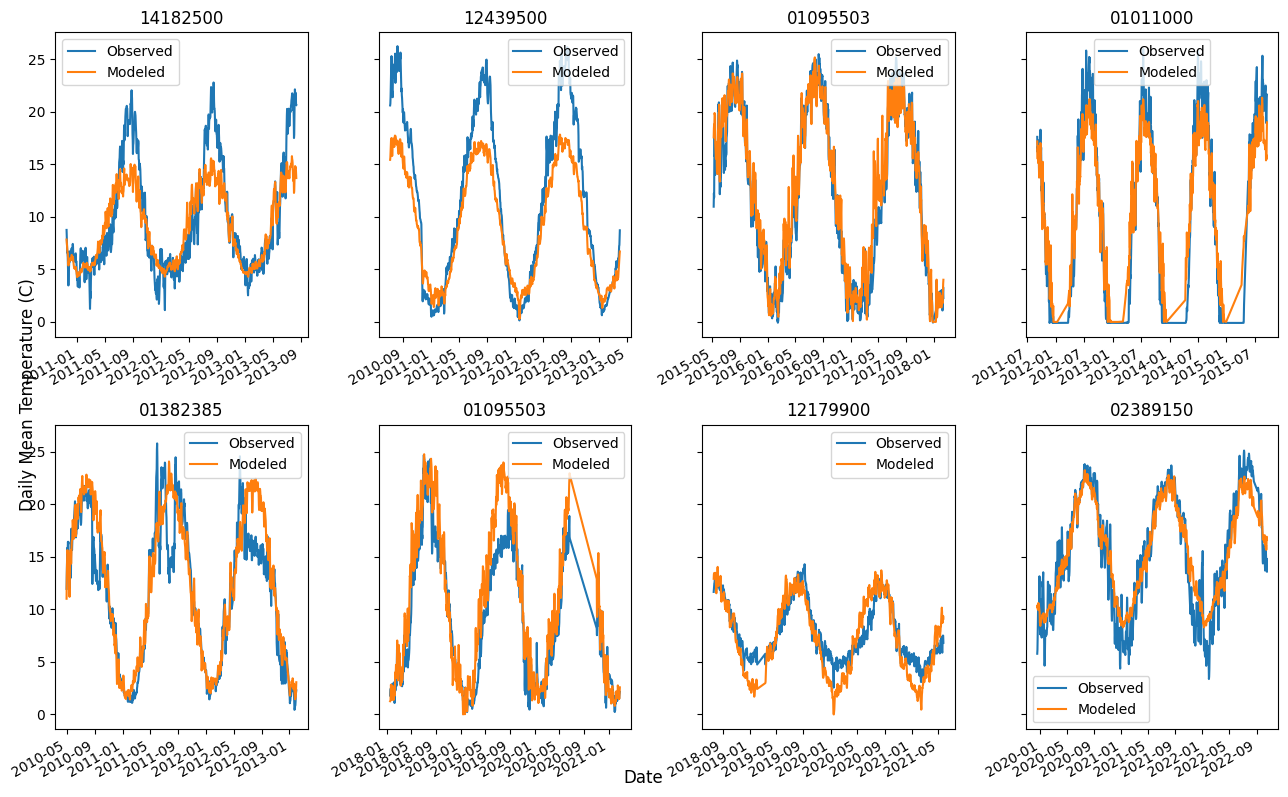

In [7]:
Ny = 2
Nx = 4
fig, axes = plt.subplots(Ny, Nx, figsize=(13, 8), sharey=True)
for i, ID in enumerate(ids):
    ax = axes[i // Nx, i % Nx]
    dat = kfr[kfr["id"] == ID]
    if len(dat) > 1100:
        start = rng.integers(0, len(dat) - 1000)
        dat = dat.iloc[start:(start + 1000), :]
    dat.plot(x="date", y="temperature", label="Observed", ax=ax)
    dat.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(ID)

plt.tight_layout()
fig.supxlabel("Date")
_ = fig.supylabel("Daily Mean Temperature (C)")

plt.savefig("results/SmarterGAMSample.png", dpi=1000)